In [ ]:
!unzip archive.zip -d /shared/home/nas6781/

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import numpy as np

# Define disease labels
disease_labels = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]

# Set pandas option to avoid warnings
pd.set_option('future.no_silent_downcasting', True)
base_dir = '/shared/home/nas6781/'

# Custom Dataset Class with improved validation
class CheXpertDataset(Dataset):
    def __init__(self, csv_file, transform=None, validate_files=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform or transforms.ToTensor()
        self.disease_labels = disease_labels
        # self.valid_indices = None

        # if validate_files:
        #     self.valid_indices = self.validate_dataset()

    # def validate_dataset(self):
    #     """Pre-filter dataset to only include valid images with labels"""
    #     print("Validating dataset files and labels...")
    #     valid_indices = []

    #     for idx, row in self.data.iterrows():
    #         if idx % 1000 == 0:
    #             print(f"Validated {idx}/{len(self.data)} entries...")

    #         image_path = row['Path']

    #         if image_path.startswith('._'):
    #             continue

    #         full_path = os.path.join(base_dir, image_path)

    #         if not os.path.isfile(full_path):
    #             continue

    #         labels = row[disease_labels].fillna(0).replace(-1, 0)
    #         if labels.isnull().all():
    #             continue

    #         valid_indices.append(idx)

    #     print(f"Found {len(valid_indices)} valid images out of {len(self.data)} entries")
    #     return valid_indices

    def __len__(self):
        # return len(self.valid_indices) if self.valid_indices is not None else len(self.data)
        return len(self.data)

    def __getitem__(self, idx):
        # if self.valid_indices is not None:
        #     data_idx = self.valid_indices[idx]
        # else:
        #     data_idx = idx
    
        # row = self.data.iloc[data_idx]
        row = self.data.iloc[idx]
        image_path = row['Path']
        full_path = os.path.join(base_dir, image_path)
    
        try:
            image = Image.open(full_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {full_path}: {e}")
            # Return a black placeholder
            return torch.zeros(3, 224, 224), torch.zeros(len(self.disease_labels))
    
        # Force resize BEFORE any other transform
        image = transforms.Resize((224, 224))(image)
        
        if self.transform:
            image = self.transform(image)
    
        labels = row[disease_labels].fillna(0).replace(-1, 0)
        labels = labels.infer_objects(copy=False).astype(float)
        return image, torch.FloatTensor(labels.values)

# Define Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# No need for collate_fn if we validate the dataset first
def get_balanced_binary_datasets(dataset, train_ratio=0.7, val_ratio=0.15):
    """Creates balanced binary classification datasets"""
    print("\nCreating balanced binary datasets...")

    pos_indices = []
    neg_indices = []

    for i in range(len(dataset)):
        _, labels = dataset[i]

        if torch.sum(labels) > 0:
            pos_indices.append(i)
        else:
            neg_indices.append(i)

    print(f"Found {len(pos_indices)} positive samples and {len(neg_indices)} negative samples")

    min_count = min(len(pos_indices), len(neg_indices))
    balanced_indices = pos_indices[:min_count] + neg_indices[:min_count]
    print(f"Using {len(balanced_indices)} balanced samples ({min_count} per class)")

    np.random.shuffle(balanced_indices)

    total = len(balanced_indices)
    train_size = int(train_ratio * total)
    val_size = int(val_ratio * total)

    train_indices = balanced_indices[:train_size]
    val_indices = balanced_indices[train_size:train_size+val_size]
    test_indices = balanced_indices[train_size+val_size:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    print(f"Split into {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test samples")

    return train_dataset, val_dataset, test_dataset

# Binary collate function
def binary_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    binary_labels = torch.stack([(label.sum() > 0).float().unsqueeze(0) for label in labels])
    return images, binary_labels


/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


alternative code

Validating dataset files and labels...
Validated 0/223414 entries...
Validated 1000/223414 entries...
Validated 2000/223414 entries...
Validated 3000/223414 entries...
Validated 4000/223414 entries...
Validated 5000/223414 entries...
Validated 6000/223414 entries...
Validated 7000/223414 entries...
Validated 8000/223414 entries...
Validated 9000/223414 entries...
Validated 10000/223414 entries...
Validated 11000/223414 entries...
Validated 12000/223414 entries...
Validated 13000/223414 entries...
Validated 14000/223414 entries...
Validated 15000/223414 entries...
Validated 16000/223414 entries...
Validated 17000/223414 entries...
Validated 18000/223414 entries...
Validated 19000/223414 entries...
Validated 20000/223414 entries...
Validated 21000/223414 entries...
Validated 22000/223414 entries...
Validated 23000/223414 entries...
Validated 24000/223414 entries...
Validated 25000/223414 entries...
Validated 26000/223414 entries...
Validated 27000/223414 entries...
Validated 28000/223414

/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss = 0.6059, Val Loss = 0.5797
Epoch 2: Train Loss = 0.5206, Val Loss = 0.5977
Epoch 3: Train Loss = 0.4108, Val Loss = 0.6981
Epoch 4: Train Loss = 0.2476, Val Loss = 0.8891
Epoch 5: Train Loss = 0.0749, Val Loss = 1.0517
Epoch 6: Train Loss = 0.0211, Val Loss = 1.1865
Early stopping triggered.


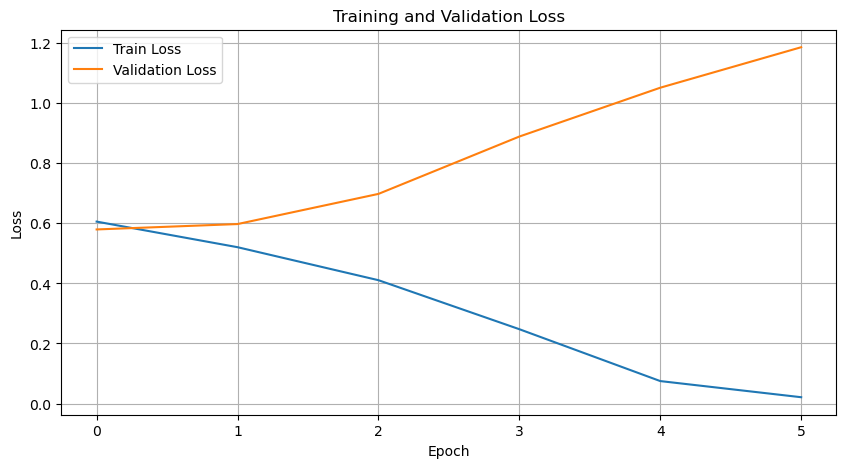

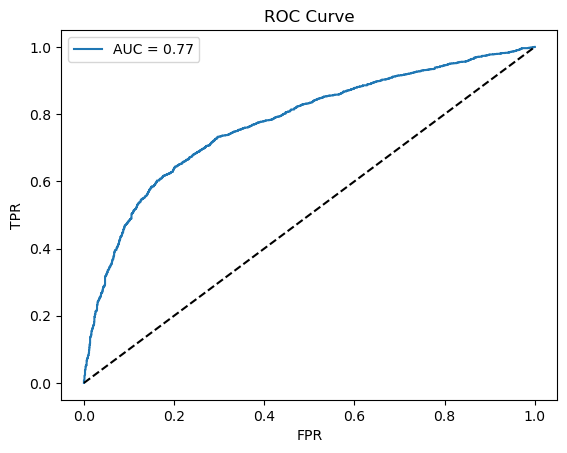

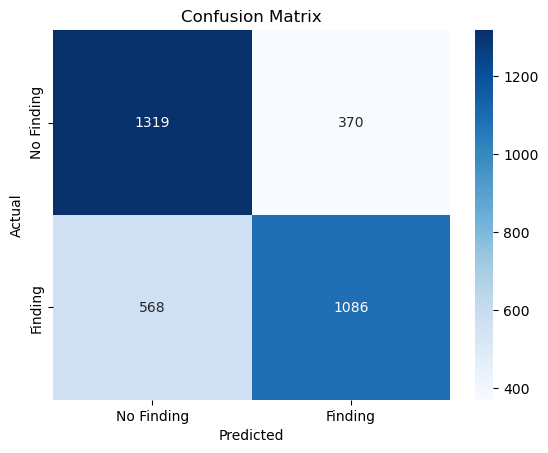

Accuracy: 0.7194
Precision: 0.7459
Recall: 0.6566
F1: 0.6984
Auroc: 0.7747


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision import transforms
from PIL import Image

# Dataset and collate_fn assumed to be defined elsewhere:
# - CheXpertDataset
# - get_balanced_binary_datasets
# - binary_collate_fn

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct, train_total = 0, 0

        for images, labels in train_loader:
            if images.size(0) == 0:
                continue

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss, val_batches = 0.0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                if images.size(0) == 0:
                    continue

                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curves.png')
    plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images)

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.savefig('roc_curve.png')
    plt.show()

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return metrics

def main():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    full_dataset = CheXpertDataset(csv_file='/shared/home/nas6781/CheXpert-v1.0-small/train.csv', transform=None, validate_files=True)
    train_dataset, val_dataset, test_dataset = get_balanced_binary_datasets(full_dataset)

    # Assign transforms
    train_dataset.transform = train_transform
    val_dataset.transform = val_test_transform
    test_dataset.transform = val_test_transform

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=binary_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=binary_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=binary_collate_fn)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)  # No Sigmoid inside model!
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

    plot_training_curves(train_losses, val_losses)

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'chest_xray_binary_model.pth')

    metrics = evaluate_model(model, test_loader, device)
    with open('binary_evaluation_results.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    for k, v in metrics.items():
        print(f"{k.capitalize()}: {v:.4f}")

if __name__ == '__main__':
    main()


Validating dataset files and labels...
Validated 0/223414 entries...
Validated 1000/223414 entries...
Validated 2000/223414 entries...
Validated 3000/223414 entries...
Validated 4000/223414 entries...
Validated 5000/223414 entries...
Validated 6000/223414 entries...
Validated 7000/223414 entries...
Validated 8000/223414 entries...
Validated 9000/223414 entries...
Validated 10000/223414 entries...
Validated 11000/223414 entries...
Validated 12000/223414 entries...
Validated 13000/223414 entries...
Validated 14000/223414 entries...
Validated 15000/223414 entries...
Validated 16000/223414 entries...
Validated 17000/223414 entries...
Validated 18000/223414 entries...
Validated 19000/223414 entries...
Validated 20000/223414 entries...
Validated 21000/223414 entries...
Validated 22000/223414 entries...
Validated 23000/223414 entries...
Validated 24000/223414 entries...
Validated 25000/223414 entries...
Validated 26000/223414 entries...
Validated 27000/223414 entries...
Validated 28000/223414

/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss = 0.6024, Val Loss = 0.5725
Epoch 2: Train Loss = 0.5177, Val Loss = 0.5849
Epoch 3: Train Loss = 0.3989, Val Loss = 0.6525
Epoch 4: Train Loss = 0.2279, Val Loss = 0.8939
Epoch 5: Train Loss = 0.1332, Val Loss = 1.2047
Epoch 6: Train Loss = 0.0921, Val Loss = 1.1994
Early stopping triggered.


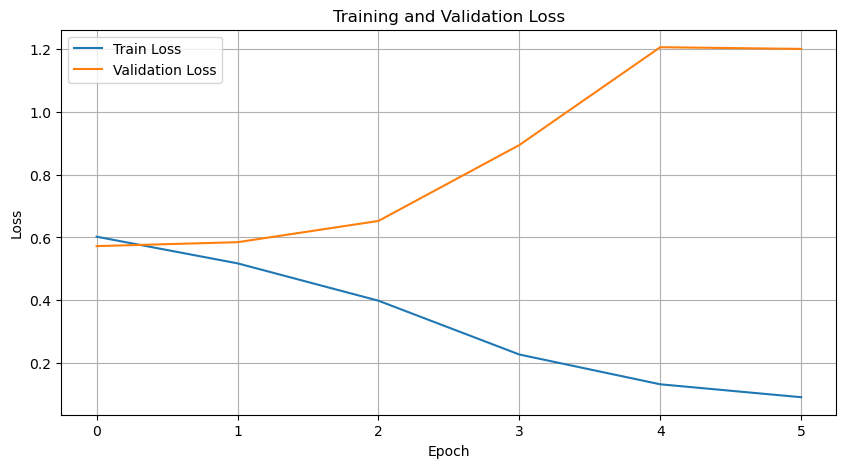

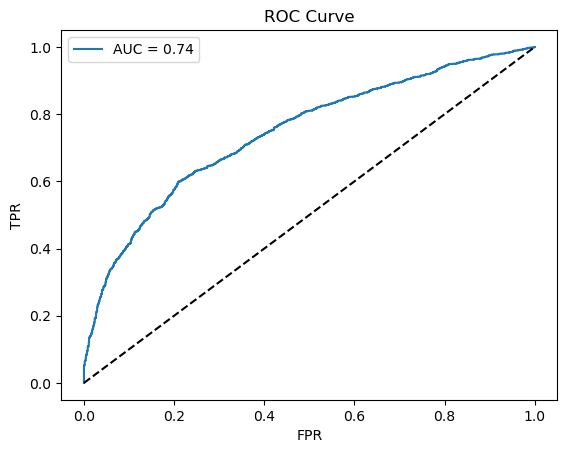

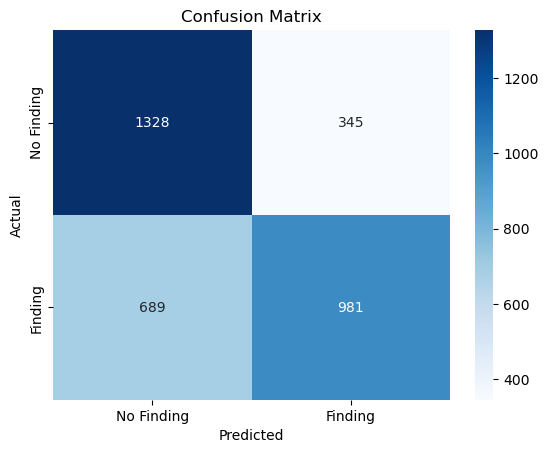

Accuracy: 0.6907
Precision: 0.7398
Recall: 0.5874
F1: 0.6549
Auroc: 0.7450


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision import transforms
from PIL import Image

# Dataset and collate_fn assumed to be defined elsewhere:
# - CheXpertDataset
# - get_balanced_binary_datasets
# - binary_collate_fn

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct, train_total = 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            if images.size(0) == 0:
                continue

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = (outputs > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss, val_batches = 0.0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                if images.size(0) == 0:
                    continue

                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curves.png')
    plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(outputs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.savefig('roc_curve.png')
    plt.show()

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return metrics

def main():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = CheXpertDataset(csv_file='/shared/home/nas6781/CheXpert-v1.0-small/train.csv', transform=transform, validate_files=True)
    train_dataset, val_dataset, test_dataset = get_balanced_binary_datasets(dataset)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=binary_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=binary_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=binary_collate_fn)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = resnet18(pretrained=True)
    model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 1), nn.Sigmoid())
    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    plot_training_curves(train_losses, val_losses)

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'chest_xray_binary_model.pth')

    metrics = evaluate_model(model, test_loader, device)
    with open('binary_evaluation_results.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    for k, v in metrics.items():
        print(f"{k.capitalize()}: {v:.4f}")

if __name__ == '__main__':
    main()

In [2]:
import pandas as pd
import ast

# Load from scratch
df = pd.read_csv('/shared/home/nas6781/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv')
df = df.dropna(subset=['Labels', 'ImageID'])
df['ImageID'] = df['ImageID'].astype(str)
df['ImageID'] = df['ImageID'].str.replace('.dicom', '.png')
df['ImageID'] = df['ImageID'].str.replace('.dcm', '.png')
def safe_eval(val):
    try:
        return ast.literal_eval(str(val))
    except:
        return []

df['Labels'] = df['Labels'].apply(safe_eval)

df['no_findings'] = df['Labels'].apply(
    lambda x: 1 if len(x) == 1 and isinstance(x[0], str) and x[0].strip().lower() == 'normal' else 0
)
import os

image_dir = '/shared/home/nas6781/Padchest'
existing_images = set(os.listdir(image_dir))

df = df[df['ImageID'].isin(existing_images)]


In [3]:
from PIL import Image
import torch
from torch.utils.data import Dataset

class PadChestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['ImageID'])

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row['no_findings'], dtype=torch.float32)
        return image, label
from torchvision import transforms

from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = PadChestDataset(df, image_dir=image_dir, transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

images, labels = next(iter(loader))
print("Batch shape:", images.shape)
print("Batch labels:", labels[:5])

def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curves.png')
    plt.show()

from PIL import UnidentifiedImageError
from tqdm import tqdm  # optional but helps track progress

def cache_valid_indices_and_labels(dataset):
    pos_indices = []
    neg_indices = []

    for i in tqdm(range(len(dataset)), desc="Caching labels"):
        row = dataset.df.iloc[i]
        img_path = os.path.join(dataset.image_dir, row['ImageID'])

        # Skip if image does not exist or cannot be opened
        if not os.path.exists(img_path):
            continue

        try:
            Image.open(img_path).verify()  # Very fast check without full load
        except (UnidentifiedImageError, OSError):
            continue

        label = torch.tensor(row['no_findings'], dtype=torch.float32)
        if label > 0:
            neg_indices.append(i)  # no findings = negative
        else:
            pos_indices.append(i)  # any finding = positive

    return pos_indices, neg_indices

def get_balanced_binary_datasets_fast(dataset, train_ratio=0.7, val_ratio=0.15):
    print("\nCreating balanced binary datasets (fast)...")
    pos_indices, neg_indices = cache_valid_indices_and_labels(dataset)

    print(f"Found {len(pos_indices)} positive and {len(neg_indices)} negative samples")
    min_count = min(len(pos_indices), len(neg_indices))
    balanced_indices = pos_indices[:min_count] + neg_indices[:min_count]
    np.random.shuffle(balanced_indices)

    total = len(balanced_indices)
    train_size = int(train_ratio * total)
    val_size = int(val_ratio * total)

    train_indices = balanced_indices[:train_size]
    val_indices = balanced_indices[train_size:train_size + val_size]
    test_indices = balanced_indices[train_size + val_size:]

    return (Subset(dataset, train_indices),
            Subset(dataset, val_indices),
            Subset(dataset, test_indices))
    
def binary_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    binary_labels = torch.stack([(label.sum() > 0).float().unsqueeze(0) for label in labels])
    return images, binary_labels

Batch shape: torch.Size([16, 3, 224, 224])
Batch labels: tensor([1., 0., 0., 0., 0.])


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.models import efficientnet_b0
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import json
import random
from concurrent.futures import ProcessPoolExecutor
import os

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            if images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels.squeeze(1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss, val_batches = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                if images.size(0) == 0:
                    continue
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels.squeeze(1))
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    return metrics

def run_experiment(params, device):
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load dataset
    dataset = PadChestDataset(
        dataframe=df,  # Your PadChest dataframe
        image_dir='/shared/home/nas6781/Padchest',
        transform=transform
    )

    # Create balanced splits
    train_dataset, val_dataset, test_dataset = get_balanced_binary_datasets_fast(dataset)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )

    # Initialize model
    model = efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model = model.to(device)

    # Training setup
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['learning_rate'],
        weight_decay=params['weight_decay']
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        patience=params['scheduler_patience'],
        factor=params['scheduler_factor']
    )

    # Train model
    model, train_losses, val_losses = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        device,
        num_epochs=params['num_epochs'],
        patience=params['early_stopping_patience']
    )

    # Evaluate
    metrics = evaluate_model(model, test_loader, device)
    
    return metrics, train_losses, val_losses

def generate_random_params():
    """Generate random parameters within reasonable ranges"""
    return {
        'learning_rate': random.choice([1e-4, 5e-4, 1e-3]),
        'batch_size': random.choice([16, 32, 64]),
        'weight_decay': random.choice([1e-5, 1e-4, 1e-3]),
        'scheduler_patience': random.choice([2, 3, 5]),
        'scheduler_factor': random.choice([0.1, 0.5]),
        'early_stopping_patience': random.choice([3, 5, 7]),
        'num_epochs': random.choice([20, 30, 40])
    }

def run_experiment_wrapper(args):
    """Wrapper function for parallel execution"""
    params, device = args
    try:
        metrics, train_losses, val_losses = run_experiment(params, device)
        return {
            'params': params,
            'metrics': metrics,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
    except Exception as e:
        print(f"Error in experiment: {e}")
        return None

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Number of experiments to run
    num_experiments = 20  # Reduced from 486 to 20 random combinations
    
    # Generate random parameter combinations
    param_combinations = [generate_random_params() for _ in range(num_experiments)]
    
    # Store results
    results = []
    best_auroc = 0
    best_params = None

    # Run experiments in parallel
    print(f"Running {num_experiments} experiments in parallel...")
    with ProcessPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on your CPU cores
        future_to_params = {
            executor.submit(run_experiment_wrapper, (params, device)): params 
            for params in param_combinations
        }
        
        for future in future_to_params:
            result = future.result()
            if result is not None:
                results.append(result)
                
                # Update best parameters
                if result['metrics']['auroc'] > best_auroc:
                    best_auroc = result['metrics']['auroc']
                    best_params = result['params']
                    
                print(f"Completed experiment with AUROC: {result['metrics']['auroc']:.4f}")

    # Save results
    with open('hyperparameter_tuning_results.json', 'w') as f:
        json.dump(results, f, indent=2)

    # Print best parameters
    print("\nBest Parameters:")
    print(json.dumps(best_params, indent=2))
    print(f"Best AUROC: {best_auroc:.4f}")

if __name__ == '__main__':
    main() 

Using device: cuda
Running 20 experiments in parallel...

Creating balanced binary datasets (fast)...

Creating balanced binary datasets (fast)...


Caching labels:   0%|          | 0/28540 [00:00<?, ?it/s]


Creating balanced binary datasets (fast)...
Creating balanced binary datasets (fast)...



Caching labels:   0%|          | 14/28540 [00:00<22:02, 21.57it/s]






Creating balanced binary datasets (fast)...


Caching labels:   0%|          | 0/28540 [00:00<?, ?it/s]


Creating balanced binary datasets (fast)...


Caching labels:   0%|          | 0/28540 [00:00<?, ?it/s]


Creating balanced binary datasets (fast)...


Caching labels:   0%|          | 0/28540 [00:00<?, ?it/s]


Creating balanced binary datasets (fast)...


Caching labels:   0%|          | 17/28540 [00:00<06:20, 74.99it/s] 






Creating balanced binary datasets (fast)...
Creating balanced binary datasets (fast)...



Caching labels:   0%|          | 0/28540 [00:00<?, ?it/s]


Creating balanced binary datasets (fast)...

Creating balanced binary datasets (fast)...

Caching labels:   0%|          | 0/28540 [00:00<?, ?it/s]

Caching labels:   0%|          | 18/28540 [00:00<02:49, 167.90it/s]

KeyboardInterrupt: 

Caching labels: 100%|██████████| 28540/28540 [26:05<00:00, 18.23it/s]  




Found 19333 positive and 9207 negative samplesFound 19333 positive and 9207 negative samplesFound 19333 positive and 9207 negative samples



Found 19333 positive and 9207 negative samples



/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

Error in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodError in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodError in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodError in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method




Creating balanced binary datasets (fast)...


Caching labels:   0%|          | 0/28540 [00:00<?, ?it/s]


Creating balanced binary datasets (fast)...
Creating balanced binary datasets (fast)...

Creating balanced binary datasets (fast)...



Caching labels: 100%|██████████| 28540/28540 [27:56<00:00, 17.02it/s] 




Found 19333 positive and 9207 negative samplesFound 19333 positive and 9207 negative samplesFound 19333 positive and 9207 negative samples




Found 19333 positive and 9207 negative samples
Error in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodError in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodError in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodError in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method




Creating balanced binary datasets (fast)...
Creating balanced binary datasets (fast)...
Creating balanced binary datasets (fast)...
Creating balanced binary datasets (fast)...





Caching labels: 100%|██████████| 28540/28540 [25:14<00:00, 18.85it/s]  



Found 19333 positive and 9207 negative samplesFound 19333 positive and 9207 negative samples

Found 19333 positive and 9207 negative samplesFound 19333 positive and 9207 negative samples


Error in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodError in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodError in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start methodError in experiment: Cannot re-initialize CUDA in forked subprocess. To use CUDA with multiprocessing, you must use the 'spawn' start method





In [5]:
def get_balanced_binary_datasets_from_each(chexpert_dataset, padchest_dataset, train_ratio=0.7, val_ratio=0.15):
    def get_pos_neg_indices(dataset, name=""):
        pos, neg = [], []
        for i in tqdm(range(len(dataset)), desc=f"Caching labels for {name}"):
            try:
                _, label = dataset[i]
                if torch.sum(label) > 0:
                    pos.append(i)
                else:
                    neg.append(i)
            except Exception as e:
                print(f"Error at index {i} in {name}: {e}")
        return pos, neg

    chexpert_pos, chexpert_neg = get_pos_neg_indices(chexpert_dataset, "CheXpert")
    padchest_pos, padchest_neg = get_pos_neg_indices(padchest_dataset, "PadChest")

    min_pos = min(len(chexpert_pos), len(padchest_pos))
    min_neg = min(len(chexpert_neg), len(padchest_neg))

    def split_indices(indices, train_ratio, val_ratio):
        np.random.shuffle(indices)
        total = len(indices)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)
        return indices[:train_end], indices[train_end:val_end], indices[val_end:]

    splits = {}
    for label, chex_indices, pad_indices in [
        ('pos', chexpert_pos[:min_pos], padchest_pos[:min_pos]),
        ('neg', chexpert_neg[:min_neg], padchest_neg[:min_neg])
    ]:
        chex_train, chex_val, chex_test = split_indices(chex_indices, train_ratio, val_ratio)
        pad_train, pad_val, pad_test = split_indices(pad_indices, train_ratio, val_ratio)
        splits[label] = {
            'train': chex_train + pad_train,
            'val': chex_val + pad_val,
            'test': chex_test + pad_test
        }

    train_indices = splits['pos']['train'] + splits['neg']['train']
    val_indices = splits['pos']['val'] + splits['neg']['val']
    test_indices = splits['pos']['test'] + splits['neg']['test']
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    np.random.shuffle(test_indices)

    combined_dataset = ConcatDataset([chexpert_dataset, padchest_dataset])
    return (Subset(combined_dataset, train_indices),
            Subset(combined_dataset, val_indices),
            Subset(combined_dataset, test_indices))



Creating balanced binary datasets (fast)...


Caching labels: 100%|██████████| 28540/28540 [17:11<00:00, 27.67it/s]


Found 19333 positive and 9207 negative samples


/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss = 0.6773, Val Loss = 0.6522
Epoch 2: Train Loss = 0.6483, Val Loss = 0.6511
Epoch 3: Train Loss = 0.6367, Val Loss = 0.6382
Epoch 4: Train Loss = 0.6199, Val Loss = 0.6442
Epoch 5: Train Loss = 0.5953, Val Loss = 0.6387
Epoch 6: Train Loss = 0.5599, Val Loss = 0.6626
Epoch 7: Train Loss = 0.5165, Val Loss = 0.6758
Epoch 8: Train Loss = 0.4570, Val Loss = 0.7546
Early stopping triggered.


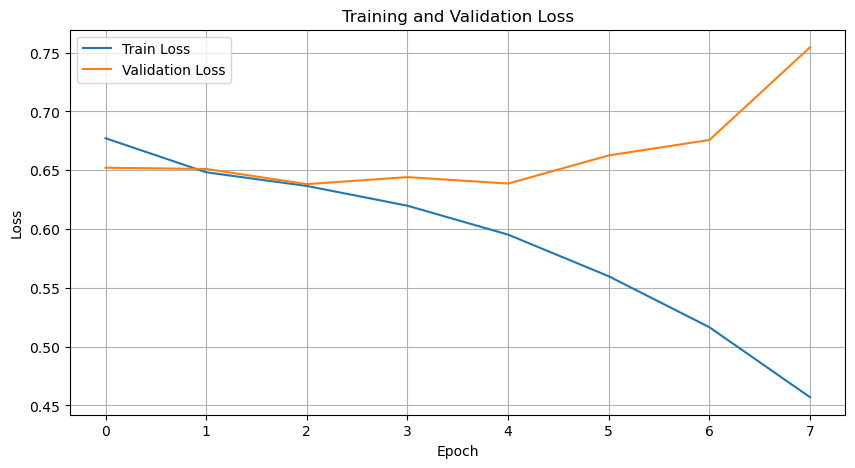

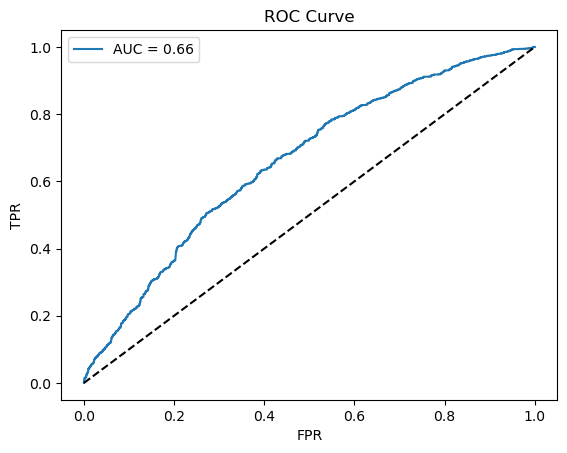

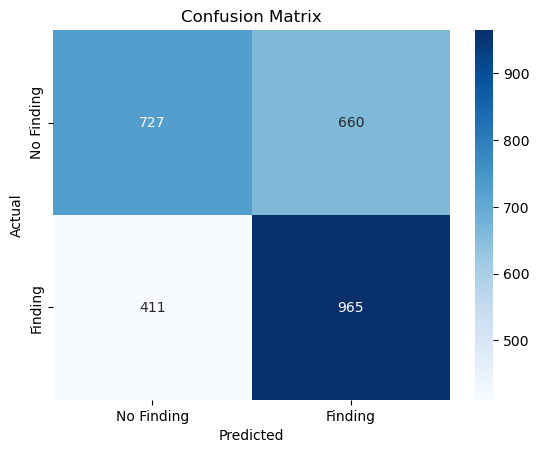

Accuracy: 0.6124
Precision: 0.5938
Recall: 0.7013
F1: 0.6431
Auroc: 0.6589


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import Subset

# Assuming the PadChestDataset is defined as provided
class PadChestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['ImageID'])

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Ensure the labels are in the correct shape [batch_size, 1]
        label = torch.tensor(row['no_findings'], dtype=torch.float32).unsqueeze(0)
        return image, label


# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct, train_total = 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            if images.size(0) == 0:
                continue

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = (outputs > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss, val_batches = 0.0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                if images.size(0) == 0:
                    continue

                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

# Evaluation function
def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(outputs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.savefig('roc_curve.png')
    plt.show()

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return metrics

# Main function
def main():
    # Assuming the `df` dataframe and `image_dir` are defined correctly
    # For example, loading your dataframe might look like:
    # df = pd.read_csv('path_to_your_csv_file.csv') 
    # image_dir = '/path/to/images'

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    # Initialize PadChestDataset with the correct arguments
    dataset = PadChestDataset(dataframe=df, image_dir=image_dir, transform=transform)

    # Split dataset into train, validation, and test sets
    # You can create a custom split or use sklearn.model_selection.train_test_split
    train_dataset, val_dataset, test_dataset = get_balanced_binary_datasets_fast(dataset)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load ResNet18 model and modify the final layer for binary classification
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)
    criterion = nn.BCEWithLogitsLoss()
    model = model.to(device)

    # Define loss function and optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train the model
    model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, device)

    # Plot training curves
    plot_training_curves(train_losses, val_losses)

    # Save the trained model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'padchest_binary_model.pth')

    # Evaluate the model on the test set
    metrics = evaluate_model(model, test_loader, device)
    with open('binary_evaluation_results.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    # Print metrics
    for k, v in metrics.items():
        print(f"{k.capitalize()}: {v:.4f}")

if __name__ == '__main__':
    main()




Creating balanced binary datasets (fast)...


Caching labels: 100%|██████████| 28540/28540 [18:05<00:00, 26.29it/s] 
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Found 19333 positive and 9207 negative samples
Epoch 1: Train Loss = 0.6837, Val Loss = 0.6724
Epoch 2: Train Loss = 0.6686, Val Loss = 0.6639
Epoch 3: Train Loss = 0.6572, Val Loss = 0.6536
Epoch 4: Train Loss = 0.6542, Val Loss = 0.6550
Epoch 5: Train Loss = 0.6448, Val Loss = 0.6523
Epoch 6: Train Loss = 0.6422, Val Loss = 0.6502
Epoch 7: Train Loss = 0.6379, Val Loss = 0.6528
Epoch 8: Train Loss = 0.6340, Val Loss = 0.6370
Epoch 9: Train Loss = 0.6276, Val Loss = 0.6493
Epoch 10: Train Loss = 0.6263, Val Loss = 0.6536
Epoch 11: Train Loss = 0.6217, Val Loss = 0.6498
Epoch 12: Train Loss = 0.6080, Val Loss = 0.6576
Epoch 13: Train Loss = 0.6004, Val Loss = 0.6616
Early stopping triggered.


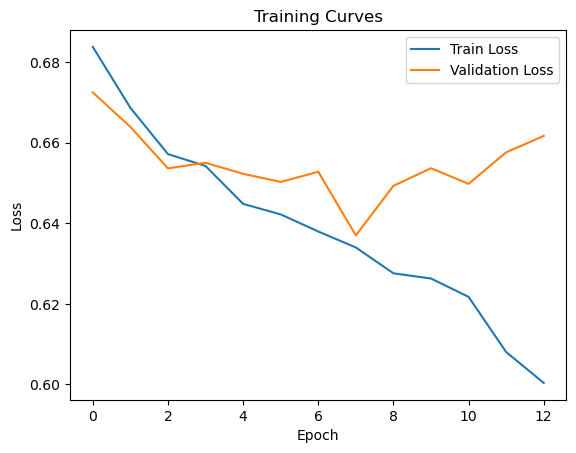

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision import transforms
from PIL import Image
import os

# PadChestDataset remains the same
class PadChestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['ImageID'])

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(row['no_findings'], dtype=torch.float32).unsqueeze(0)
        return image, label


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            if images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels.squeeze(1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss, val_batches = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                if images.size(0) == 0:
                    continue
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels.squeeze(1))
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses


def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.savefig('roc_curve.png')
    plt.show()

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return metrics


def plot_training_curves(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_curves.png')
    plt.show()


def main():
    # Assume df and image_dir are already defined
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])

    dataset = PadChestDataset(dataframe=df, image_dir=image_dir, transform=transform)
    train_dataset, val_dataset, test_dataset = get_balanced_binary_datasets_fast(dataset)

    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model = model.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device)

    plot_training_curves(train_losses, val_losses)

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'efficientnet_binary_model.pth')

    metrics = evaluate_model(model, test_loader, device)
    with open('binary_evaluation_results.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    for k, v in metrics.items():
        print(f"{k.capitalize()}: {v:.4f}")


if __name__ == '__main__':
    main()


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision.models import resnet18
import pandas as pd
import ast

def load_padchest_data():
    # Load PadChest dataset
    df = pd.read_csv('/shared/home/nas6781/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv')
    df = df.dropna(subset=['Labels', 'ImageID'])
    df['ImageID'] = df['ImageID'].astype(str)
    df['ImageID'] = df['ImageID'].str.replace('.dicom', '.png')
    df['ImageID'] = df['ImageID'].str.replace('.dcm', '.png')
    
    def safe_eval(val):
        try:
            return ast.literal_eval(str(val))
        except:
            return []
    
    df['Labels'] = df['Labels'].apply(safe_eval)
    
    # Create binary label for no findings
    df['no_findings'] = df['Labels'].apply(
        lambda x: 1 if len(x) == 1 and isinstance(x[0], str) and x[0].strip().lower() == 'normal' else 0
    )
    
    # Filter for existing images
    import os
    image_dir = '/shared/home/nas6781/Padchest'
    existing_images = set(os.listdir(image_dir))
    df = df[df['ImageID'].isin(existing_images)]
    
    return df

def load_chexpert_model(model_path, device):
    # Initialize model architecture
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model = model.to(device)
    
    # Load saved weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def evaluate_on_padchest(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (CheXpert on PadChest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig('chexpert_on_padchest_roc.png')
    plt.close()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title('Confusion Matrix (CheXpert on PadChest)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('chexpert_on_padchest_cm.png')
    plt.close()

    return metrics

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load PadChest data
    print("Loading PadChest data...")
    df = load_padchest_data()
    print(f"Loaded {len(df)} PadChest images")

    # Load PadChest dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create dataset
    padchest_dataset = PadChestDataset(
        dataframe=df,
        image_dir='/shared/home/nas6781/Padchest',
        transform=transform
    )

    # Get test dataset
    _, _, test_dataset = get_balanced_binary_datasets_fast(padchest_dataset)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Load CheXpert model
    model = load_chexpert_model('chest_xray_binary_model.pth', device)

    # Evaluate
    metrics = evaluate_on_padchest(model, test_loader, device)

    # Save results
    with open('chexpert_on_padchest_results.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    # Print results
    print("\nEvaluation Results (CheXpert on PadChest):")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

if __name__ == '__main__':
    main() 

Using device: cuda
Loading PadChest data...
Loaded 28540 PadChest images

Creating balanced binary datasets (fast)...


Caching labels: 100%|██████████| 28540/28540 [15:35<00:00, 30.52it/s]  
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Found 19333 positive and 9207 negative samples

Evaluation Results (CheXpert on PadChest):
Accuracy: 0.5020
Precision: 0.5024
Recall: 0.9986
F1: 0.6684
Auroc: 0.4879


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Define disease labels
disease_labels = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]

# Set pandas option to avoid warnings
pd.set_option('future.no_silent_downcasting', True)
base_dir = '/shared/home/nas6781/'
# Custom Dataset Class
class CheXpertDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.disease_labels = disease_labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # Get the path and ensure it doesn't contain hidden system files
        image_path = row['Path']

        if image_path.startswith('._'):
            return None  # here
        image_path = base_dir + image_path
        try:
            image = Image.open(image_path).convert('RGB')
        except (FileNotFoundError, IOError):
            # Return None for missing images
            return None

        if self.transform:
            image = self.transform(image)

        # Process labels with explicit type conversion to avoid warnings
        labels = row[disease_labels].fillna(0).replace(-1, 0)
        labels = labels.infer_objects(copy=False).astype(float)
        return image, torch.FloatTensor(labels.values)

# Define Transformations (Resizing and Normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize images
])

# Custom collate function to handle None values
def collate_fn(batch):
    # Filter out None values
    batch = [item for item in batch if item is not None]

    # If batch is empty, return empty tensors
    if not batch:
        return torch.empty(0), torch.empty(0)

    # Unzip the batch
    images, labels = zip(*batch)

    # Stack the images and labels
    images = torch.stack(images)
    labels = torch.stack(labels)

    return images, labels

# Create Dataset
dataset = CheXpertDataset(csv_file='/shared/home/nas6781/CheXpert-v1.0-small/train.csv', transform=transform)

# Create DataLoader with custom collate function and larger batch size
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn, num_workers=4)

# Test the DataLoader
print(dataloader)
for images, labels in dataloader:
    # Skip empty batches
    if images.size(0) == 0:
        continue
    print(f"Batch Image Shape: {images.shape}")  # Expected: [batch_size, 3, 224, 224]
    print(f"Batch Labels Shape: {labels.shape}")  # Expected: [batch_size, num_labels]
    break


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random  # Added missing import
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.metrics import average_precision_score
import torchmetrics
from torchmetrics.classification import MultilabelAUROC, MultilabelPrecisionRecallCurve

class ChestXrayModel(nn.Module):
    def __init__(self, num_classes=1):  # Changed to 1 for binary classification
        super(ChestXrayModel, self).__init__()
        # Load pretrained ResNet18
        self.resnet = resnet18(pretrained=True)
        
        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Single sigmoid for binary classification
        )

    def forward(self, x):
        return self.resnet(x)

def get_balanced_dataset(dataset):
    no_finding_items = []
    has_finding_items = []

    for i in range(len(dataset)):
        item = dataset[i]
        if item is None:
            continue
        image, label = item
        if label is None:
            continue
        
        # Binary label: 1 = Has Finding (any finding), 0 = No Finding (all labels 0)
        binary_label = 1 if label.sum() > 0 else 0
        
        if binary_label == 0:
            no_finding_items.append(item)
        else:
            has_finding_items.append(item)

    # Match the number of No Findings
    min_len = min(len(no_finding_items), len(has_finding_items))
    print(f"Undersampling to {min_len} samples per class.")

    balanced_items = no_finding_items[:min_len] + has_finding_items[:min_len]
    random.shuffle(balanced_items)

    # Wrap in a Dataset subclass (e.g., TensorDataset or custom wrapper)
    class SimpleDataset(torch.utils.data.Dataset):
        def __init__(self, items):
            self.items = items
        def __getitem__(self, idx):
            return self.items[idx]
        def __len__(self):
            return len(self.items)

    return SimpleDataset(balanced_items)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):
    model.train()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            if images.size(0) == 0:
                continue
                
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()  # Zero gradients before computing loss
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Calculate accuracy
            preds = (outputs > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], '
                      f'Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}, '
                      f'Accuracy: {train_correct/train_total:.4f}')
        
        # Calculate average loss for the epoch
        epoch_loss = running_loss / len(train_loader)  # Fixed to use len(train_loader)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_batches = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                if images.size(0) == 0:
                    continue
                    
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                val_batches += 1
        
        avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')  # Prevent division by zero
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"New best validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"EarlyStopping counter: {patience_counter} out of {patience}")
            
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, val_losses

def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_curves.png')
    plt.show()

def evaluate_model(model, test_loader, device, class_names=['Finding']):
    model.eval()
    all_labels = []
    all_preds = []
    all_scores = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
                
            images = images.to(device)
            # Labels should already be binary from the collate_fn
            binary_labels = labels
            
            # Forward pass
            outputs = model(images)
            preds = (outputs > 0.5).float()
            
            all_labels.append(binary_labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(outputs.cpu())
    
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_scores = torch.cat(all_scores, dim=0).numpy()

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_scores)
    
    # Print results
    print("\n=== Model Performance ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auroc': auroc
    }
    
    return results

# Add this debug function to check label distribution
def check_label_distribution_safe(dataset, max_samples=None):
    no_finding_count = 0
    finding_count = 0
    scanned = 0

    for i, item in enumerate(dataset):
        if max_samples and scanned >= max_samples:
            break

        if item is None:
            continue

        _, labels = item
        if labels is None:
            continue

        # Check if this is binary (1D) or multi-label
        if labels.dim() > 1 and labels.size(1) > 1:
            # Multi-label case
            is_finding = labels.sum() > 0
        else:
            # Binary case
            is_finding = labels[0] == 1
            
        if not is_finding:
            no_finding_count += 1
        else:
            finding_count += 1
        scanned += 1

        if scanned % 500 == 0:
            print(f"Scanned {scanned} valid samples...")

    total = no_finding_count + finding_count
    if total == 0:
        print("No valid samples found.")
        return 0, 0

    print(f"\nLabel Distribution (based on {total} samples):")
    print(f"No Finding: {no_finding_count} ({no_finding_count/total*100:.2f}%)")
    print(f"Has Finding: {finding_count} ({finding_count/total*100:.2f}%)")
    return no_finding_count, finding_count


def verify_binary_conversion(dataloader):
    print("\nVerifying binary label conversion...")
    for images, labels in dataloader:
        if images.size(0) == 0:
            continue
            
        # Verify label shape
        assert labels.dim() == 2 and labels.size(1) == 1, \
            f"Expected binary labels of shape (batch_size, 1), got {labels.shape}"
        
        # Verify labels are binary
        assert torch.all((labels == 0) | (labels == 1)), \
            "Labels should be binary (0 or 1)"
        
        # Print sample distribution
        num_findings = labels.sum().item()
        num_no_findings = len(labels) - num_findings
        print(f"Batch distribution:")
        print(f"No Findings: {num_no_findings}")
        print(f"Has Findings: {num_findings}")
        break

def interpret_results(metrics):
    print("\nResults Interpretation:")
    print("----------------------")
    print("Positive class (1) = Has Findings")
    print("Negative class (0) = No Findings")
    print("\nMetrics interpretation:")
    print(f"Accuracy: {metrics['accuracy']:.4f} - Overall correct predictions")
    print(f"Precision: {metrics['precision']:.4f} - When model predicts 'Has Findings', it's correct this often")
    print(f"Recall: {metrics['recall']:.4f} - Of all actual cases with findings, model catches this proportion")
    print(f"F1: {metrics['f1']:.4f} - Harmonic mean of precision and recall")
    print(f"AUROC: {metrics['auroc']:.4f} - Model's ability to distinguish between classes")

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    #
    # Initialize model for binary classification
    model = ChestXrayModel(num_classes=1)
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)
    
    # Check distribution of original dataset
    print("\nChecking original dataset distribution:")
    no_finding, has_finding = check_label_distribution_safe(dataset)
    
    # Rebalance dataset before splitting
    balanced_dataset = get_balanced_dataset(dataset)
    
    # Then split the balanced dataset
    dataset_size = len(balanced_dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(
        balanced_dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print("\nChecking training set distribution:")
    check_label_distribution_safe(train_dataset)

    print("\nChecking validation set distribution:")
    check_label_distribution_safe(val_dataset)

    print("\nChecking test set distribution:")
    check_label_distribution_safe(test_dataset)
    
    # Create DataLoaders with binary collate function
    def binary_collate_fn(batch):
        batch = [item for item in batch if item is not None]
        if not batch:
            return torch.empty(0), torch.empty(0)
        
        images, labels = zip(*batch)
        images = torch.stack(images)
        labels = torch.stack(labels)
        
        # Convert to binary: "Finding" = any label is 1; "No Finding" = all labels are 0
        binary_labels = (labels.sum(dim=1) > 0).float().unsqueeze(1)
        
        # Optional debug
        if torch.rand(1) < 0.01:
            print("\nBatch Label Debug:")
            for i in range(min(5, len(labels))):
                print(f"Original multi-label: {labels[i].tolist()}")
                print(f"Converted binary label: {binary_labels[i].item()}")
                print("-" * 30)
        
        return images, binary_labels

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                            collate_fn=binary_collate_fn, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                          collate_fn=binary_collate_fn, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                           collate_fn=binary_collate_fn, num_workers=4)

    # Verify dataloader conversion
    print("\nVerifying training dataloader:")
    verify_binary_conversion(train_loader)
    print("\nVerifying validation dataloader:")
    verify_binary_conversion(val_loader)
    print("\nVerifying test dataloader:")
    verify_binary_conversion(test_loader)

    # Train the model
    print("\n=== Starting training... ===")
    model, train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=8,
        patience=7
    )

    # Plot training curves
    plot_training_curves(train_losses, val_losses)

    # Save the model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'chest_xray_binary_model.pth')
    
    # Evaluate the model
    print("\n=== Starting evaluation... ===")
    metrics = evaluate_model(model, test_loader, device)

    # Save evaluation results
    import json
    with open('binary_evaluation_results.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    # Interpret results
    interpret_results(metrics)

    return model, metrics

if __name__ == "__main__":
    # Import missing modules for dataset handling
    from PIL import Image
    from torchvision import transforms
    main()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision.models import efficientnet_b0
import pandas as pd
from tqdm import tqdm
import os
from torch.utils.data import Subset

def cache_valid_indices_and_labels_chexpert(dataset):
    pos_indices = []
    neg_indices = []

    for i in tqdm(range(len(dataset)), desc="Caching labels"):
        try:
            _, labels = dataset[i]
            if torch.sum(labels) > 0:
                pos_indices.append(i)
            else:
                neg_indices.append(i)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    return pos_indices, neg_indices

def get_balanced_binary_datasets_fast(dataset, train_ratio=0.7, val_ratio=0.15):
    print("\nCreating balanced binary datasets (fast)...")
    pos_indices, neg_indices = cache_valid_indices_and_labels_chexpert(dataset)

    print(f"Found {len(pos_indices)} positive and {len(neg_indices)} negative samples")
    min_count = min(len(pos_indices), len(neg_indices))
    balanced_indices = pos_indices[:min_count] + neg_indices[:min_count]
    np.random.shuffle(balanced_indices)

    total = len(balanced_indices)
    train_size = int(train_ratio * total)
    val_size = int(val_ratio * total)

    train_indices = balanced_indices[:train_size]
    val_indices = balanced_indices[train_size:train_size + val_size]
    test_indices = balanced_indices[train_size + val_size:]

    return (Subset(dataset, train_indices),
            Subset(dataset, val_indices),
            Subset(dataset, test_indices))

def load_chexpert_data():
    # Load CheXpert dataset
    df = pd.read_csv('/shared/home/nas6781/CheXpert-v1.0-small/train.csv')
    
    # Define disease labels
    disease_labels = [
        'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
        'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
        'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
    ]
    
    # Convert labels to binary (any finding vs no finding)
    df['no_findings'] = df[disease_labels].apply(
        lambda x: 1 if all(v == 0 for v in x) else 0, axis=1
    )
    
    return df

def load_padchest_model(model_path, device):
    # Initialize model architecture
    model = efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model = model.to(device)
    
    # Load saved weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def evaluate_on_chexpert(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (PadChest on CheXpert)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig('padchest_on_chexpert_roc.png')
    plt.close()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title('Confusion Matrix (PadChest on CheXpert)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('padchest_on_chexpert_cm.png')
    plt.close()

    return metrics

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load CheXpert dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create dataset
    print("Loading CheXpert dataset...")
    chexpert_dataset = CheXpertDataset(
        csv_file='/shared/home/nas6781/CheXpert-v1.0-small/train.csv',
        transform=transform,
        validate_files=True
    )
    print(f"Loaded {len(chexpert_dataset)} CheXpert images")

    # Get test dataset
    print("Creating balanced test dataset...")
    _, _, test_dataset = get_balanced_binary_datasets_fast(chexpert_dataset)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=32, 
        shuffle=False, 
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    print(f"Created test dataset with {len(test_dataset)} images")

    # Load PadChest model
    print("Loading PadChest model...")
    model = load_padchest_model('efficientnet_binary_model.pth', device)

    # Evaluate
    print("Evaluating model...")
    metrics = evaluate_on_chexpert(model, test_loader, device)

    # Save results
    with open('padchest_on_chexpert_results.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    # Print results
    print("\nEvaluation Results (PadChest on CheXpert):")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

if __name__ == '__main__':
    main() 

In [5]:
class PadChestDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['ImageID'])

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Ensure the labels are in the correct shape [batch_size, 1]
        label = torch.tensor(row['no_findings'], dtype=torch.float32).unsqueeze(0)
        return image, label

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision.models import efficientnet_b0
import pandas as pd
from tqdm import tqdm
import os

def cache_valid_indices_and_labels_combined(dataset):
    pos_indices = []
    neg_indices = []

    for i in tqdm(range(len(dataset)), desc="Caching labels"):
        try:
            _, labels = dataset[i]
            if torch.sum(labels) > 0:
                pos_indices.append(i)
            else:
                neg_indices.append(i)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    return pos_indices, neg_indices

def get_balanced_binary_datasets_fast(dataset, train_ratio=0.7, val_ratio=0.15):
    print("\nCreating balanced binary datasets (fast)...")
    pos_indices, neg_indices = cache_valid_indices_and_labels_combined(dataset)

    print(f"Found {len(pos_indices)} positive and {len(neg_indices)} negative samples")
    min_count = min(len(pos_indices), len(neg_indices))
    balanced_indices = pos_indices[:min_count] + neg_indices[:min_count]
    np.random.shuffle(balanced_indices)

    total = len(balanced_indices)
    train_size = int(train_ratio * total)
    val_size = int(val_ratio * total)

    train_indices = balanced_indices[:train_size]
    val_indices = balanced_indices[train_size:train_size + val_size]
    test_indices = balanced_indices[train_size + val_size:]

    return (Subset(dataset, train_indices),
            Subset(dataset, val_indices),
            Subset(dataset, test_indices))

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            if images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels.squeeze(1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss, val_batches = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                if images.size(0) == 0:
                    continue
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels.squeeze(1))
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def evaluate_model(model, test_loader, device, dataset_name):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (Combined Model on {dataset_name})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(f'combined_model_{dataset_name.lower()}_roc.png')

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title(f'Confusion Matrix (Combined Model on {dataset_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'combined_model_{dataset_name.lower()}_cm.png')
    plt.close()

    return metrics

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load CheXpert dataset
    print("Loading CheXpert dataset...")
    chexpert_dataset = CheXpertDataset(
        csv_file='/shared/home/nas6781/CheXpert-v1.0-small/train.csv',
        transform=transform,
        validate_files=True
    )
    print(f"Loaded {len(chexpert_dataset)} CheXpert images")

    # Load PadChest dataset
    print("Loading PadChest dataset...")
    padchest_dataset = PadChestDataset(
        dataframe=df,  # Your PadChest dataframe
        image_dir='/shared/home/nas6781/Padchest',
        transform=transform
    )
    print(f"Loaded {len(padchest_dataset)} PadChest images")

    # Combine datasets
    combined_dataset = ConcatDataset([chexpert_dataset, padchest_dataset])
    print(f"Combined dataset size: {len(combined_dataset)}")

    # Create balanced splits
    print("Creating balanced splits...")
    train_dataset, val_dataset, test_dataset = get_balanced_binary_datasets_fast(combined_dataset)
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )

    # Initialize model
    print("Initializing model...")
    model = efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model = model.to(device)

    # Training setup
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    # Train model
    print("Training model...")
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, device
    )

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'combined_model.pth')

     # Get balanced test sets for each dataset
    _, _, chexpert_test_dataset = get_balanced_binary_datasets_fast(chexpert_dataset)
    _, _, padchest_test_dataset = get_balanced_binary_datasets_fast(padchest_dataset)
    
    chexpert_test_loader = DataLoader(
        chexpert_test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    
    padchest_test_loader = DataLoader(
        padchest_test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )

    # Evaluate on both datasets
    print("\nEvaluating on CheXpert...")
    chexpert_metrics = evaluate_model(model, chexpert_test_loader, device, "CheXpert")
    with open('combined_model_chexpert_results.json', 'w') as f:
        json.dump(chexpert_metrics, f, indent=2)

    print("\nEvaluating on PadChest...")
    padchest_metrics = evaluate_model(model, padchest_test_loader, device, "PadChest")
    with open('combined_model_padchest_results.json', 'w') as f:
        json.dump(padchest_metrics, f, indent=2)

    # Print results
    print("\nResults on CheXpert:")
    for metric, value in chexpert_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    print("\nResults on PadChest:")
    for metric, value in padchest_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

if __name__ == '__main__':
    main() 

Using device: cuda
Loading CheXpert dataset...
Loaded 223414 CheXpert images
Loading PadChest dataset...
Loaded 28540 PadChest images
Combined dataset size: 251954
Creating balanced splits...

Creating balanced binary datasets (fast)...


Caching labels: 100%|██████████| 251954/251954 [1:53:01<00:00, 37.15it/s]  
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Found 221480 positive and 30474 negative samples
Train: 42663, Val: 9142, Test: 9143
Initializing model...
Training model...
Epoch 1: Train Loss = 0.3513, Val Loss = 0.3285
Epoch 2: Train Loss = 0.3166, Val Loss = 0.3303
Epoch 3: Train Loss = 0.2874, Val Loss = 0.3407
Epoch 4: Train Loss = 0.2446, Val Loss = 0.4003
Epoch 5: Train Loss = 0.1765, Val Loss = 0.4611


In [ ]:
def get_balanced_binary_datasets_from_each(chexpert_dataset, padchest_dataset, train_ratio=0.7, val_ratio=0.15):
    def get_pos_neg_indices(dataset, name=""):
        pos, neg = [], []
        for i in tqdm(range(len(dataset)), desc=f"Caching labels for {name}"):
            try:
                _, label = dataset[i]
                if torch.sum(label) > 0:
                    pos.append(i)
                else:
                    neg.append(i)
            except Exception as e:
                print(f"Error at index {i} in {name}: {e}")
        return pos, neg

    chexpert_pos, chexpert_neg = get_pos_neg_indices(chexpert_dataset, "CheXpert")
    padchest_pos, padchest_neg = get_pos_neg_indices(padchest_dataset, "PadChest")

    min_pos = min(len(chexpert_pos), len(padchest_pos))
    min_neg = min(len(chexpert_neg), len(padchest_neg))

    def split_indices(indices, train_ratio, val_ratio):
        np.random.shuffle(indices)
        total = len(indices)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)
        return indices[:train_end], indices[train_end:val_end], indices[val_end:]

    splits = {}
    for label, chex_indices, pad_indices in [
        ('pos', chexpert_pos[:min_pos], padchest_pos[:min_pos]),
        ('neg', chexpert_neg[:min_neg], padchest_neg[:min_neg])
    ]:
        chex_train, chex_val, chex_test = split_indices(chex_indices, train_ratio, val_ratio)
        pad_train, pad_val, pad_test = split_indices(pad_indices, train_ratio, val_ratio)
        splits[label] = {
            'train': chex_train + pad_train,
            'val': chex_val + pad_val,
            'test': chex_test + pad_test
        }

    train_indices = splits['pos']['train'] + splits['neg']['train']
    val_indices = splits['pos']['val'] + splits['neg']['val']
    test_indices = splits['pos']['test'] + splits['neg']['test']
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    np.random.shuffle(test_indices)

    combined_dataset = ConcatDataset([chexpert_dataset, padchest_dataset])
    return (Subset(combined_dataset, train_indices),
            Subset(combined_dataset, val_indices),
            Subset(combined_dataset, test_indices))


In [ ]:
def get_balanced_binary_datasets_from_each(chexpert_dataset, padchest_dataset, train_ratio=0.7, val_ratio=0.15):
    def get_pos_neg_indices(dataset, name=""):
        pos, neg = [], []
        for i in tqdm(range(len(dataset)), desc=f"Caching labels for {name}"):
            try:
                _, label = dataset[i]
                if torch.sum(label) > 0:
                    pos.append(i)
                else:
                    neg.append(i)
            except Exception as e:
                print(f"Error at index {i} in {name}: {e}")
        return pos, neg

    chexpert_pos, chexpert_neg = get_pos_neg_indices(chexpert_dataset, "CheXpert")
    padchest_pos, padchest_neg = get_pos_neg_indices(padchest_dataset, "PadChest")

    min_pos = min(len(chexpert_pos), len(padchest_pos))
    min_neg = min(len(chexpert_neg), len(padchest_neg))

    def split_indices(indices, train_ratio, val_ratio):
        np.random.shuffle(indices)
        total = len(indices)
        train_end = int(train_ratio * total)
        val_end = train_end + int(val_ratio * total)
        return indices[:train_end], indices[train_end:val_end], indices[val_end:]

    splits = {}
    for label, chex_indices, pad_indices in [
        ('pos', chexpert_pos[:min_pos], padchest_pos[:min_pos]),
        ('neg', chexpert_neg[:min_neg], padchest_neg[:min_neg])
    ]:
        chex_train, chex_val, chex_test = split_indices(chex_indices, train_ratio, val_ratio)
        pad_train, pad_val, pad_test = split_indices(pad_indices, train_ratio, val_ratio)
        splits[label] = {
            'train': chex_train + pad_train,
            'val': chex_val + pad_val,
            'test': chex_test + pad_test
        }

    train_indices = splits['pos']['train'] + splits['neg']['train']
    val_indices = splits['pos']['val'] + splits['neg']['val']
    test_indices = splits['pos']['test'] + splits['neg']['test']
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    np.random.shuffle(test_indices)

    combined_dataset = ConcatDataset([chexpert_dataset, padchest_dataset])
    return (Subset(combined_dataset, train_indices),
            Subset(combined_dataset, val_indices),
            Subset(combined_dataset, test_indices))


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision.models import efficientnet_b0
import pandas as pd
from tqdm import tqdm
import os

def cache_valid_indices_and_labels_combined(dataset):
    pos_indices = []
    neg_indices = []

    for i in tqdm(range(len(dataset)), desc="Caching labels"):
        try:
            _, labels = dataset[i]
            if torch.sum(labels) > 0:
                pos_indices.append(i)
            else:
                neg_indices.append(i)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    return pos_indices, neg_indices

def get_balanced_binary_datasets_fast(dataset, train_ratio=0.7, val_ratio=0.15):
    print("\nCreating balanced binary datasets (fast)...")
    pos_indices, neg_indices = cache_valid_indices_and_labels_combined(dataset)

    print(f"Found {len(pos_indices)} positive and {len(neg_indices)} negative samples")
    min_count = min(len(pos_indices), len(neg_indices))
    balanced_indices = pos_indices[:min_count] + neg_indices[:min_count]
    np.random.shuffle(balanced_indices)

    total = len(balanced_indices)
    train_size = int(train_ratio * total)
    val_size = int(val_ratio * total)

    train_indices = balanced_indices[:train_size]
    val_indices = balanced_indices[train_size:train_size + val_size]
    test_indices = balanced_indices[train_size + val_size:]

    return (Subset(dataset, train_indices),
            Subset(dataset, val_indices),
            Subset(dataset, test_indices))

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            if images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels.squeeze(1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss, val_batches = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                if images.size(0) == 0:
                    continue
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels.squeeze(1))
                val_loss += loss.item()
                val_batches += 1

        avg_val_loss = val_loss / val_batches if val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

def evaluate_model(model, test_loader, device, dataset_name):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (Combined Model on {dataset_name})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(f'combined_model_{dataset_name.lower()}_roc.png')
    plt.close()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title(f'Confusion Matrix (Combined Model on {dataset_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'combined_model_{dataset_name.lower()}_cm.png')
    plt.close()

    return metrics

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load CheXpert dataset
    print("Loading CheXpert dataset...")
    chexpert_dataset = CheXpertDataset(
        csv_file='/shared/home/nas6781/CheXpert-v1.0-small/train.csv',
        transform=transform,
        validate_files=True
    )
    print(f"Loaded {len(chexpert_dataset)} CheXpert images")

    # Load PadChest dataset
    print("Loading PadChest dataset...")
    padchest_dataset = PadChestDataset(
        dataframe=df,  # Your PadChest dataframe
        image_dir='/shared/home/nas6781/Padchest',
        transform=transform
    )
    print(f"Loaded {len(padchest_dataset)} PadChest images")

    # Combine datasets
    combined_dataset = ConcatDataset([chexpert_dataset, padchest_dataset])
    print(f"Combined dataset size: {len(combined_dataset)}")

    # Create balanced splits
    print("Creating balanced splits...")
    train_dataset, val_dataset, test_dataset = get_balanced_binary_datasets_from_each(chexpert_dataset, padchest_dataset)
    print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )

    # Initialize model
    print("Initializing model...")
    model = efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model = model.to(device)

    # Training setup
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    # Train model
    print("Training model...")
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, device
    )

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
    }, 'combined_model.pth')

    # Create separate test loaders for each dataset
    chexpert_test_loader = DataLoader(
        Subset(chexpert_dataset, range(len(chexpert_dataset))),
        batch_size=32,
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    padchest_test_loader = DataLoader(
        Subset(padchest_dataset, range(len(padchest_dataset))),
        batch_size=32,
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )

    # Evaluate on both datasets
    print("\nEvaluating on CheXpert...")
    chexpert_metrics = evaluate_model(model, chexpert_test_loader, device, "CheXpert")
    with open('combined_model_chexpert_results.json', 'w') as f:
        json.dump(chexpert_metrics, f, indent=2)

    print("\nEvaluating on PadChest...")
    padchest_metrics = evaluate_model(model, padchest_test_loader, device, "PadChest")
    with open('combined_model_padchest_results.json', 'w') as f:
        json.dump(padchest_metrics, f, indent=2)

    # Print results
    print("\nResults on CheXpert:")
    for metric, value in chexpert_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    print("\nResults on PadChest:")
    for metric, value in padchest_metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

if __name__ == '__main__':
    main() 

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision.models import resnet18
import pandas as pd
import ast
import os

def load_padchest_data():
    """Load and preprocess PadChest dataset"""
    print("Loading PadChest data...")
    df = pd.read_csv('/shared/home/nas6781/PADCHEST_chest_x_ray_images_labels_160K_01.02.19.csv')
    df = df.dropna(subset=['Labels', 'ImageID'])
    df['ImageID'] = df['ImageID'].astype(str)
    df['ImageID'] = df['ImageID'].str.replace('.dicom', '.png')
    df['ImageID'] = df['ImageID'].str.replace('.dcm', '.png')
    
    def safe_eval(val):
        try:
            return ast.literal_eval(str(val))
        except:
            return []
    
    df['Labels'] = df['Labels'].apply(safe_eval)
    
    # Create binary label for no findings
    df['no_findings'] = df['Labels'].apply(
        lambda x: 1 if len(x) == 1 and isinstance(x[0], str) and x[0].strip().lower() == 'normal' else 0
    )
    
    # Filter for existing images
    image_dir = '/shared/home/nas6781/Padchest'
    existing_images = set(os.listdir(image_dir))
    df = df[df['ImageID'].isin(existing_images)]
    
    print(f"Loaded {len(df)} PadChest images")
    return df

def load_chexpert_model(model_path, device):
    """Load trained CheXpert model"""
    print("Loading CheXpert model...")
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model = model.to(device)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("Model loaded successfully")
    return model

def plot_roc_curve(labels, scores, save_path):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(labels, scores)
    auc = roc_auc_score(labels, scores)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (CheXpert on PadChest)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    plt.close()

def plot_confusion_matrix(labels, preds, save_path):
    """Plot confusion matrix"""
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title('Confusion Matrix (CheXpert on PadChest)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(save_path)
    plt.close()

def plot_metrics_bar(metrics, save_path):
    """Plot metrics as a bar chart"""
    plt.figure(figsize=(10, 6))
    metrics_names = list(metrics.keys())
    values = list(metrics.values())
    
    bars = plt.bar(metrics_names, values)
    plt.title('Performance Metrics (CheXpert on PadChest)')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def evaluate_on_padchest(model, test_loader, device):
    """Evaluate model on PadChest test set"""
    print("Evaluating model on PadChest...")
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    # Create plots
    os.makedirs('evaluation_plots', exist_ok=True)
    plot_roc_curve(all_labels, all_scores, 'evaluation_plots/roc_curve.png')
    plot_confusion_matrix(all_labels, all_preds, 'evaluation_plots/confusion_matrix.png')
    plot_metrics_bar(metrics, 'evaluation_plots/metrics.png')

    return metrics

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data and model
    df = load_padchest_data()
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create dataset
    padchest_dataset = PadChestDataset(
        dataframe=df,
        image_dir='/shared/home/nas6781/Padchest',
        transform=transform
    )

    # Get test dataset
    _, _, test_dataset = get_balanced_binary_datasets_fast(padchest_dataset)
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        collate_fn=binary_collate_fn
    )

    # Load CheXpert model
    model = load_chexpert_model('chest_xray_binary_model.pth', device)

    # Evaluate
    metrics = evaluate_on_padchest(model, test_loader, device)

    # Save results
    with open('chexpert_on_padchest_results.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    # Print results
    print("\nEvaluation Results (CheXpert on PadChest):")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

if __name__ == '__main__':
    main() 

Using device: cuda
Loading PadChest data...
Loaded 28540 PadChest images

Creating balanced binary datasets (fast)...


Caching labels: 100%|██████████| 28540/28540 [21:34<00:00, 22.04it/s] 
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Found 19333 positive and 9207 negative samples
Loading CheXpert model...
Model loaded successfully
Evaluating model on PadChest...

Evaluation Results (CheXpert on PadChest):
Accuracy: 0.5005
Precision: 0.5009
Recall: 0.9986
F1: 0.6671
Auroc: 0.4972


In [9]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision.models import efficientnet_b0
import pandas as pd
from tqdm import tqdm
import os
from torch.utils.data import Subset

def cache_valid_indices_and_labels_chexpert(dataset):
    pos_indices = []
    neg_indices = []

    for i in tqdm(range(len(dataset)), desc="Caching labels"):
        try:
            _, labels = dataset[i]
            if torch.sum(labels) > 0:
                pos_indices.append(i)
            else:
                neg_indices.append(i)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    return pos_indices, neg_indices

def get_balanced_binary_datasets_fast(dataset, train_ratio=0.7, val_ratio=0.15):
    print("\nCreating balanced binary datasets (fast)...")
    pos_indices, neg_indices = cache_valid_indices_and_labels_chexpert(dataset)

    print(f"Found {len(pos_indices)} positive and {len(neg_indices)} negative samples")
    min_count = min(len(pos_indices), len(neg_indices))
    balanced_indices = pos_indices[:min_count] + neg_indices[:min_count]
    np.random.shuffle(balanced_indices)

    total = len(balanced_indices)
    train_size = int(train_ratio * total)
    val_size = int(val_ratio * total)

    train_indices = balanced_indices[:train_size]
    val_indices = balanced_indices[train_size:train_size + val_size]
    test_indices = balanced_indices[train_size + val_size:]

    return (Subset(dataset, train_indices),
            Subset(dataset, val_indices),
            Subset(dataset, test_indices))

def load_chexpert_data():
    # Load CheXpert dataset
    df = pd.read_csv('/shared/home/nas6781/CheXpert-v1.0-small/train.csv')
    
    # Define disease labels
    disease_labels = [
        'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
        'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
        'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
    ]
    
    # Convert labels to binary (any finding vs no finding)
    df['no_findings'] = df[disease_labels].apply(
        lambda x: 1 if all(v == 0 for v in x) else 0, axis=1
    )
    
    return df

def load_padchest_model(model_path, device):
    # Initialize model architecture
    model = efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model = model.to(device)
    
    # Load saved weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def evaluate_on_chexpert(model, test_loader, device):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve (PadChest on CheXpert)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig('padchest_on_chexpert_roc.png')
    plt.close()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title('Confusion Matrix (PadChest on CheXpert)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('padchest_on_chexpert_cm.png')
    plt.close()

    return metrics

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load CheXpert dataset
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create dataset
    print("Loading CheXpert dataset...")
    chexpert_dataset = CheXpertDataset(
        csv_file='/shared/home/nas6781/CheXpert-v1.0-small/train.csv',
        transform=transform,
        validate_files=True
    )
    print(f"Loaded {len(chexpert_dataset)} CheXpert images")

    # Get test dataset
    print("Creating balanced test dataset...")
    _, _, test_dataset = get_balanced_binary_datasets_fast(chexpert_dataset)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=32, 
        shuffle=False, 
        num_workers=2,
        collate_fn=binary_collate_fn
    )
    print(f"Created test dataset with {len(test_dataset)} images")

    # Load PadChest model
    print("Loading PadChest model...")
    model = load_padchest_model('efficientnet_binary_model.pth', device)

    # Evaluate
    print("Evaluating model...")
    metrics = evaluate_on_chexpert(model, test_loader, device)

    # Save results
    with open('padchest_on_chexpert_results.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    # Print results
    print("\nEvaluation Results (PadChest on CheXpert):")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")

if __name__ == '__main__':
    main() 

Using device: cuda
Loading CheXpert dataset...
Loaded 223414 CheXpert images
Creating balanced test dataset...

Creating balanced binary datasets (fast)...


Caching labels: 100%|██████████| 223414/223414 [1:00:53<00:00, 61.15it/s]
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Found 212273 positive and 11141 negative samples
Created test dataset with 3343 images
Loading PadChest model...
Evaluating model...

Evaluation Results (PadChest on CheXpert):
Accuracy: 0.5001
Precision: 0.5003
Recall: 0.9988
F1: 0.6667
Auroc: 0.5102


In [4]:
def evaluate_model(model, test_loader, device, dataset_name):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            if images.size(0) == 0:
                continue
            images = images.to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()
            
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve (Combined Model on {dataset_name})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(f'combined_model_{dataset_name.lower()}_roc.png')

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title(f'Confusion Matrix (Combined Model on {dataset_name})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'combined_model_{dataset_name.lower()}_cm.png')
    plt.close()

    return metrics


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import json
from torchvision.models import efficientnet_b0
import pandas as pd
from tqdm import tqdm
import os
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load CheXpert dataset
print("Loading CheXpert dataset...")
chexpert_dataset = CheXpertDataset(
    csv_file='/shared/home/nas6781/CheXpert-v1.0-small/train.csv',
    transform=transform,
    validate_files=True
)
print(f"Loaded {len(chexpert_dataset)} CheXpert images")

# Load PadChest dataset
print("Loading PadChest dataset...")
padchest_dataset = PadChestDataset(
    dataframe=df,  # Your PadChest dataframe
    image_dir='/shared/home/nas6781/Padchest',
    transform=transform
)
print(f"Loaded {len(padchest_dataset)} PadChest images")

# Combine datasets
combined_dataset = ConcatDataset([chexpert_dataset, padchest_dataset])
print(f"Combined dataset size: {len(combined_dataset)}")



Loading CheXpert dataset...
Loaded 223414 CheXpert images
Loading PadChest dataset...
Loaded 28540 PadChest images
Combined dataset size: 251954


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.models import efficientnet_b0
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

def get_balanced_binary_test_set(dataset, size=500):
    """Create a small balanced binary test set."""
    pos_indices = []
    neg_indices = []

    for i in range(len(dataset)):
        try:
            _, labels = dataset[i]
            if torch.sum(labels) > 0:
                pos_indices.append(i)
            else:
                neg_indices.append(i)
        except:
            continue
        if len(pos_indices) >= size // 2 and len(neg_indices) >= size // 2:
            break

    balanced_indices = pos_indices[:size // 2] + neg_indices[:size // 2]
    return Subset(dataset, balanced_indices)

def evaluate_model(model, test_loader, device, dataset_name):
    model.eval()
    all_labels, all_preds, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(1)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_scores.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_scores = torch.cat(all_scores).numpy()

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds),
        'recall': recall_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'auroc': roc_auc_score(all_labels, all_scores)
    }

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auroc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(f'{dataset_name.lower()}_roc.png')
    plt.close()

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Finding', 'Finding'],
                yticklabels=['No Finding', 'Finding'])
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{dataset_name.lower()}_cm.png')
    plt.close()

    return metrics

# ---------------- RUN EVALUATION ----------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
checkpoint = torch.load('combined_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Create test sets
chexpert_test_dataset = get_balanced_binary_test_set(chexpert_dataset)
padchest_test_dataset = get_balanced_binary_test_set(padchest_dataset)

# Create test loaders
chexpert_loader = DataLoader(chexpert_test_dataset, batch_size=64, shuffle=False, collate_fn=binary_collate_fn)
padchest_loader = DataLoader(padchest_test_dataset, batch_size=64, shuffle=False, collate_fn=binary_collate_fn)

# Evaluate
print("Evaluating on CheXpert...")
chexpert_metrics = evaluate_model(model, chexpert_loader, device, "CheXpert")
print(json.dumps(chexpert_metrics, indent=2))
with open('chexpert_eval_results.json', 'w') as f:
    json.dump(chexpert_metrics, f, indent=2)

print("Evaluating on PadChest...")
padchest_metrics = evaluate_model(model, padchest_loader, device, "PadChest")
print(json.dumps(padchest_metrics, indent=2))
with open('padchest_eval_results.json', 'w') as f:
    json.dump(padchest_metrics, f, indent=2)


/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Evaluating on CheXpert...
{
  "accuracy": 0.904,
  "precision": 0.8713235294117647,
  "recall": 0.948,
  "f1": 0.9080459770114943,
  "auroc": 0.961504
}
Evaluating on PadChest...
{
  "accuracy": 0.5,
  "precision": 0.0,
  "recall": 0.0,
  "f1": 0.0,
  "auroc": 0.505248
}


/shared/spack/opt/spack/linux-amzn2-skylake_avx512/gcc-14.1.0/miniconda3-24.3.0-zxx5jostrj4myhf7bi3oap3ylkmegd3a/envs/neuro140/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
